In [1]:
import os
import cv2
import numpy as np
from skimage import segmentation
from glob import glob
from matplotlib import pyplot as plt
import pandas as pd
import openslide as oslide
from tqdm import tqdm

In [2]:
def get_nic_with_coord(features, coords, size, inst_label):
        w = coords[:,0]
        h = coords[:,1]
        w_min = w.min()
        w_max = w.max()
        h_min = h.min()
        h_max = h.max()
        image_shape = [(w_max-w_min)//size+1,(h_max-h_min)//size+1]
        mask = np.ones((image_shape[0], image_shape[1]))
        labels = -np.ones((image_shape[0], image_shape[1]))
        features_nic = np.ones((features.shape[-1], image_shape[0], image_shape[1])) * np.nan
        coords_nic = -np.ones((image_shape[0], image_shape[1], 2))
        # Store each patch feature in the right position
        if inst_label != []:
            for patch_feature, x, y, label in zip(features, w, h, inst_label):
                coord = [x,y]
                x_nic, y_nic = (x-w_min)//size, (y-h_min)//size
                features_nic[:, x_nic, y_nic] = patch_feature
                coords_nic[x_nic, y_nic] = coord
                labels[x_nic, y_nic]=label
        else:
            for patch_feature, x, y in zip(features, w, h):
                coord = [x,y]
                x_nic, y_nic = (x-w_min)//size, (y-h_min)//size
                features_nic[:, x_nic, y_nic] = patch_feature
                coords_nic[x_nic, y_nic] = coord
            labels=[]

        # Populate NaNs
        mask[np.isnan(features_nic)[0]] = 0
        features_nic[np.isnan(features_nic)] = 0
        return features_nic, mask, labels

def get_sp_label(inst_label_nic, m_slic):
    inst_label_nic = inst_label_nic.T
    
    sp_inst_label_all = []
    
    pred_label_all = []
    
    for i in np.unique(m_slic):
        if i == 0:
            continue
        sp_inst_label = inst_label_nic[m_slic==i]
        sp_inst_label = sp_inst_label.astype(np.int32)
        sp_inst_label[sp_inst_label<0] = 0
        counts = np.bincount(sp_inst_label)
        label = np.argmax(counts)
        
        pred_label_all += [label]*sp_inst_label.shape[0]
        
        sp_inst_label_all += list(sp_inst_label)

    return sp_inst_label_all, pred_label_all

def generate_adjacency_matrix(superpixel_matrix):
    # 获取超像素矩阵的形状
    rows, cols = superpixel_matrix.shape
    num_superpixels = np.max(superpixel_matrix)+1

    # 创建邻接矩阵，并初始化为0
    adjacency_matrix = np.zeros((num_superpixels, num_superpixels), dtype=int)

    # 遍历超像素矩阵的每个像素
    for i in range(rows):
        for j in range(cols):
            current_superpixel = superpixel_matrix[i, j]
            
            if current_superpixel == 0:
                continue

            # 检查当前像素的上方和左方是否与当前超像素相邻
            if i > 0 and superpixel_matrix[i-1, j] != current_superpixel:
                adjacency_matrix[current_superpixel, superpixel_matrix[i-1, j]] = 1
                adjacency_matrix[superpixel_matrix[i-1, j], current_superpixel] = 1

            if j > 0 and superpixel_matrix[i, j-1] != current_superpixel:
                adjacency_matrix[current_superpixel, superpixel_matrix[i, j-1]] = 1
                adjacency_matrix[superpixel_matrix[i, j-1], current_superpixel] = 1

    return adjacency_matrix

In [8]:
size = 2048
file_suffix = '_1_512.npy'
n_segments_persp = 16
compactness = 50

In [10]:
fea_path = '/home/z/zeyugao/dataset/smmile_test/Res50/TCGA-B0-4945-01Z-00-DX1.590b650c-c9cb-4601-886c-fde0ccd9b90d_1_512.npy'
record = np.load(fea_path, allow_pickle=True)
features = record[()]['feature2']

coords = record[()]['index']
if type(coords[0]) is np.ndarray:
    coords_nd = np.array(coords)
else:
    coords_nd = np.array([[int(i.split('_')[0]),int(i.split('_')[1])] for i in coords])

if type(coords[0]) is np.ndarray:
        coords_nd = np.array(coords)

inst_label = record[()]['inst_label']
features = (features-features.min())/(features.max()-features.min())*255
features_nic, mask, inst_label_nic = get_nic_with_coord(features, coords_nd, size, inst_label)

data = np.transpose(features_nic, (1,2,0))

n_segments = max(10, int(features.shape[0] / n_segments_persp))
m_slic = segmentation.slic(data, n_segments=n_segments, mask=mask, compactness=compactness, start_label=1).T
m_adj = generate_adjacency_matrix(m_slic)

# sp_path = os.path.join(sp_dir, df.iloc[i,1])+file_suffix

sp_cotents = {}
sp_cotents['m_slic'] = m_slic
sp_cotents['m_adj'] = m_adj

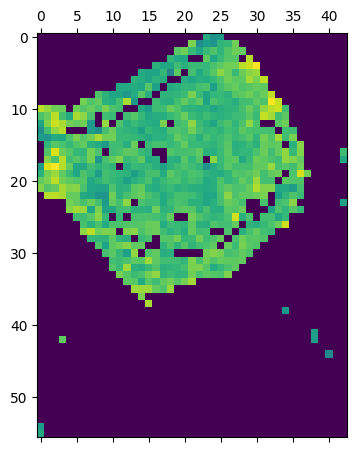

In [12]:
plt.matshow(features_nic[0,...])

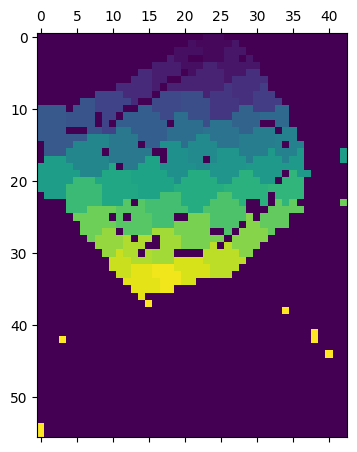

In [14]:
plt.matshow(m_slic.T)

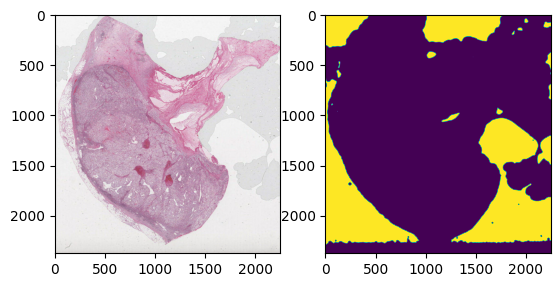

In [6]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(resized_img)
plt.subplot(1,2,2)
plt.imshow(binary_mask)